In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import inspect
currentdir = os.path.dirname(os.path.abspath(
    inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(1, parentdir+'/src')
import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import time
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import gym
import pybullet as p
import stage.envs
from stage.tasks.onelink.reaching import OneLinkReaching
from stage.utils.nn import use_gpu
use_gpu()

In [4]:
savepath = parentdir + '/data/onelink/'

In [5]:
task = OneLinkReaching(render=False)

# Read task parameters, should we use a separate class to wrap this?

nq, nv, nu, nx = task.nq, task.nv, task.nu, task.nx
dt_control, dt_env = task.dt_control, task.dt_env
q_lb, q_ub = task.q_lb, task.q_ub

In [6]:
# Setup action parameterization

from stage.controllers.actor import Actor
from stage.controllers.trivial import Identity
from stage.controllers.pd import PD

# na = 1
# action_ub = torch.Tensor(task.env.action_space.high)
# action_lb = torch.Tensor(task.env.action_space.low)
# actor = Actor(na, Identity(nq, nv, nu), action_lb, action_ub)

na = 2
gain_ub = 50 * torch.ones((nq))
gain_lb = 0. * torch.ones((nq))
action_ub = torch.cat((gain_ub, q_ub))
action_lb = torch.cat((gain_lb, q_lb))
actor = Actor(na, PD(nq, nv, nu), action_lb, action_ub)

task.cost.actor = actor

In [7]:
# Setup model learning

# from stage.dynamics.mlp import MLPDyn, DefaultDx
# dynamics = MLPDyn(nx, nq, nv, na, dt_control, DefaultDx)


from stage.dynamics.probabilistic_ensemble import ProbabilisticEnsemble, DefaultDx

ensemble_size = 5
nn_epochs = 10
batch_size = 64
    
dynamics = ProbabilisticEnsemble(nq, nv, na, dt_control, 
                                 DefaultDx,
                                 ensemble_size, 
                                 learning_rate = 0.001)

In [8]:
# Setup controller
# from stage.controllers.trivial import RandomController
# controller = RandomController(nx, actor)

from stage.controllers.ilqr import ILQR
plan_horizon = 50
controller = ILQR(dynamics, task.cost, actor, plan_horizon)

In [9]:
# Setup learner

from stage.learners.learn_and_control_model import LearnAndControlModel
learner = LearnAndControlModel(task, dynamics, controller)

In [10]:
# x = torch.Tensor([-0.5, 0.5])
# g = torch.Tensor([-1, 1])
# b_lower = torch.Tensor([0, 0])
# b_upper = torch.Tensor([1, 1])
# c_idx = (x.eq(b_lower) & (g > 0)) | (x.eq(b_upper) & (g < 0))
# f_idx = ~c_idx

In [11]:
_ = learner.learn(10, verbose=True)
learner.save_training_data(savepath+'data_pd_reg')

Network training: 100%|██████████| 10/10 [00:00<00:00, 24.86epoch(s)/s, Training loss MSE=0.23128462]


Iteration:  0
avg. decision time:  0.0033307719230651857
obs. reward:  -358.467
act. reward:  -0.40377334


Network training: 100%|██████████| 10/10 [00:01<00:00,  7.57epoch(s)/s, Training loss MSE=0.16416581]


Iteration:  1
avg. decision time:  0.44502150297164916
obs. reward:  -226.16103
act. reward:  -2.4936857


Network training: 100%|██████████| 10/10 [00:01<00:00,  5.37epoch(s)/s, Training loss MSE=0.4025674]


Iteration:  2
avg. decision time:  0.40858595371246337
obs. reward:  -45.699142
act. reward:  -2.4252238


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.12epoch(s)/s, Training loss MSE=0.48690936]


Iteration:  3
avg. decision time:  0.6531355977058411
obs. reward:  -48.399265
act. reward:  -0.03755744


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.51epoch(s)/s, Training loss MSE=0.093257174]


Iteration:  4
avg. decision time:  0.6186723971366882
obs. reward:  -79.05699
act. reward:  -0.33737653


Network training: 100%|██████████| 10/10 [00:02<00:00,  4.08epoch(s)/s, Training loss MSE=0.069287136]


Iteration:  5
avg. decision time:  0.626527123451233
obs. reward:  -48.436646
act. reward:  -0.8724917


Network training: 100%|██████████| 10/10 [00:02<00:00,  3.56epoch(s)/s, Training loss MSE=0.052832667]


Iteration:  6
avg. decision time:  0.5620921373367309
obs. reward:  -32.366833
act. reward:  -0.37635845


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.20epoch(s)/s, Training loss MSE=0.035813082]


Iteration:  7
avg. decision time:  0.516866545677185
obs. reward:  -33.028065
act. reward:  -0.42017978


Network training: 100%|██████████| 10/10 [00:04<00:00,  2.06epoch(s)/s, Training loss MSE=0.030821262]


Iteration:  8
avg. decision time:  0.5075914168357849
obs. reward:  -30.621422
act. reward:  -0.33131483


Network training: 100%|██████████| 10/10 [00:05<00:00,  1.88epoch(s)/s, Training loss MSE=0.024121488]

Iteration:  9
avg. decision time:  0.45177913188934327
obs. reward:  -34.869946
act. reward:  -0.5507586


In [13]:
traj, log = task.perform(task.goal, controller)
act_seq = traj[:, nx:nx+na]
initial_obs = traj[0, :nx]
final_obs = traj[-1, :nx]

avg. decision time:  0.5125877070426941
obs. reward:  -31.797104
act. reward:  -0.17638241


In [14]:
n_sample = 50
traj_pred = dynamics.unroll(initial_obs, 
                            act_seq, 
                            n_sample)

predicted_err = torch.norm(traj_pred[-1, :, :]-final_obs.expand(n_sample, -1), p=2, dim=1)
print (predicted_err.mean())
print (predicted_err.std())

tensor(2.0103, grad_fn=<MeanBackward0>)
tensor(2.5184, grad_fn=<StdBackward0>)


In [15]:
from stage.utils.nn import jacobian_vector_product

In [16]:
x = initial_obs.clone()
a = act_seq[0].clone()

In [17]:
# cost = task.cost.l(x, a, diff=True)

In [18]:
# from stage.controllers.ilqr import ILQR
# ilqr = ILQR(dynamics, task.cost, actor, task.task_horizon)
# rollout, sols = ilqr.optimize(initial_obs)

In [19]:
# from stage.controllers.trivial import OpenLoop
# openloop = OpenLoop(nx, actor, actions)

In [20]:
task_horizon = task.task_horizon

traj_pred_mean = torch.mean(traj_pred, dim=1)
traj_pred_std = torch.std(traj_pred, dim=1)
traj_pred_mean = traj_pred_mean.detach().cpu().numpy()
traj_pred_std = traj_pred_std.detach().cpu().numpy()
traj = traj.detach().cpu().numpy()

desired = task.cost.desired.repeat((task_horizon, 1))
desired = desired.detach().cpu().numpy()

In [21]:
font = {'family' : 'serif',
        'size'   : 22}

matplotlib.rc('font', **font)
np.set_printoptions(precision=3, linewidth=200, suppress=True)

In [22]:
# traj_pred_mean = np.load('traj_pred_mean.npy')
# traj_pred_std = np.load('traj_pred_std.npy')
# traj = np.load('traj.npy')

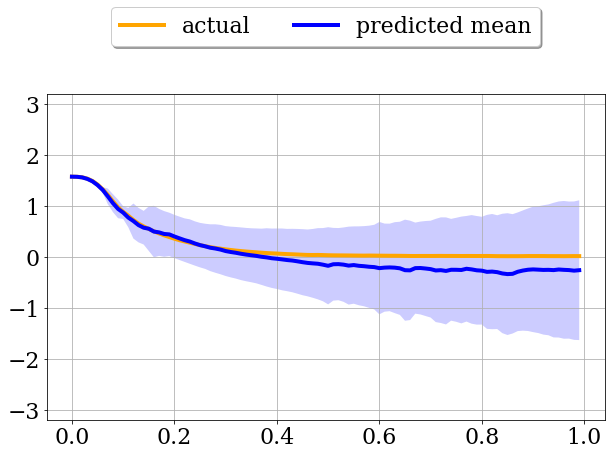

In [23]:
d = nq
dt = dt_control
fig, ax = plt.subplots(d, figsize=(10, d * 6))
t = np.arange(0.0, task_horizon*dt, dt)
lb = traj_pred_mean - traj_pred_std
ub = traj_pred_mean + traj_pred_std

for i in range(d):
    ax.plot(t, traj[:, i], lw=4, color='orange', label='actual')
    ax.plot(t, traj_pred_mean[:, i], lw=4, color='b', label='predicted mean')
#     ax[i].plot(t, desired[:, i], lw=2, color='k', ls='-.', label='desired')
    lb = traj_pred_mean - traj_pred_std
    ub = traj_pred_mean + traj_pred_std
    ax.fill_between(t, lb[:, i], ub[:, i], facecolor='blue',
                alpha=0.2)
    _ = ax.grid()
    _ = ax.set_ylim([-3.2, 3.2])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
             ncol=3, fancybox=True, shadow=True)
# fig.savefig('prediction_with_reg_150steps' + '.png', bbox_inches='tight')